In [59]:
import geopandas as gpd
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# import
import warnings
warnings.filterwarnings('ignore')
assets = '/app/assets'
data = '/app/data'

In [83]:
def get_diversity_map(level = 10):
    area_scope_columns = ['Name', 'geometry']
    area_scope = gpd.read_parquet(f'{assets}/area_scope/area_scope.parquet')
    area_scope = area_scope[area_scope_columns]
    area_crs = area_scope.crs

    land_uses = gpd.read_parquet(f'{assets}/land_uses/actual.parquet')
    land_uses = land_uses.to_crs(area_crs)

    unit_key = 'hex_id'
    unit = gpd.read_parquet(f'{data}/set/hex/level_{level}.parquet')
    unit = unit.to_crs(area_crs)

    overlay_unit_area = gpd.overlay(unit, area_scope)
    overlay_unit_landuses = gpd.overlay(unit, land_uses)

    diversity_columns = [unit_key, 'Uso', 'area_predio', 'geometry']
    overlay_unit_landuses = overlay_unit_landuses[diversity_columns]

    overlay_unit_landuses['area_uso'] = overlay_unit_landuses['geometry'].area

    unit_area_uso = overlay_unit_landuses[[unit_key, 'Uso', 'area_uso']].groupby([unit_key, 'Uso']).agg('sum').reset_index()
    unit_area_total = overlay_unit_landuses[[unit_key, 'area_uso']].groupby([unit_key]).agg('sum').reset_index().rename(columns={'area_uso': 'total_uso'})

    unit_area = pd.merge(unit_area_total, unit_area_uso, on=unit_key)

    unit_area['porcion_uso'] = unit_area['area_uso']/unit_area['total_uso']

    unit_area['informacion_uso'] = -1*unit_area['porcion_uso']*np.log2(unit_area['porcion_uso'])
    neg_filter = unit_area['informacion_uso'] < 0.000001
    unit_area.loc[neg_filter, 'informacion_uso'] = 0

    diversity = unit_area[[unit_key, 'informacion_uso']].groupby(unit_key).agg('sum').reset_index().rename(columns={'informacion_uso': 'diversity'})

    gdf_diversity = pd.merge(unit, diversity, on=unit_key)
    gdf_diversity = gpd.GeoDataFrame(gdf_diversity, geometry=gdf_diversity['geometry'])
    gdf_diversity.fillna(0, inplace=True)
    return gdf_diversity

def calculate_total_diversity():
    area_scope_columns = ['Name', 'geometry']
    area_scope = gpd.read_parquet(f'{assets}/area_scope/area_scope.parquet')
    area_scope = area_scope[area_scope_columns]
    area_crs = area_scope.crs

    land_uses = gpd.read_parquet(f'{assets}/land_uses/actual.parquet')
    land_uses = land_uses.to_crs(area_crs)
    land_uses_cols = ['Id', 'Uso', 'area_predio', 'geometry']
    land_uses = land_uses[land_uses_cols]
    
    total_area = land_uses['area_predio'].sum()
    agg_land_uses = land_uses[['Uso', 'area_predio']].groupby('Uso').agg('sum').reset_index()
    agg_land_uses['porcion_uso'] = agg_land_uses['area_predio']/total_area
    agg_land_uses['info_predio'] = -1*agg_land_uses['porcion_uso']*np.log2(agg_land_uses['porcion_uso'])
    return agg_land_uses['info_predio'].sum()

In [85]:
diversity_value = calculate_total_diversity()
diversity_value

3.018693355908966

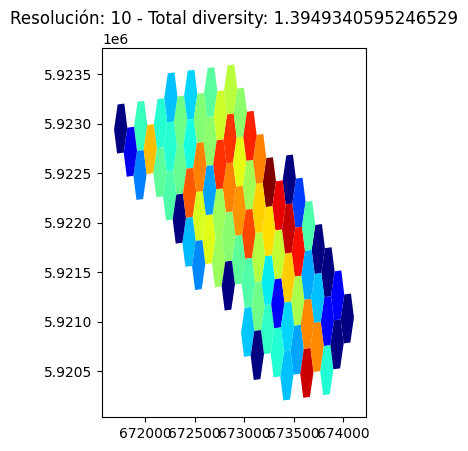

In [75]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


fig, ax = plt.subplots()
levels = [10, 11, 12, 13]
def update(frame):
    ax.clear()  # Limpia el gráfico anterior
    level = levels[frame]
    # print(resolucion)
    try:
        gdf_diversity = get_diversity_map(level)
        total_hexs = gdf_diversity.shape[0]
        
        # Asumiendo que overlay_hexs es un GeoDataFrame que quieres plotear
        gdf_diversity.plot(ax=ax, column='diversity', colormap='jet', vmin=0, vmax=3)

        total_diversity = gdf_diversity['diversity'].sum()/gdf_diversity.shape[0]
        
        # Establecer título con el número total de hexágonos
        ax.set_title(f"Resolución: {level} - Total diversity: {total_diversity}")
    except:
        ax.set_title(f"Resolución: {level} - Error")

# Crear animación
ani = FuncAnimation(fig, update, frames=range(len(levels)), repeat=False)

# Guardar la animación como un gif
ani.save('/app/data/map_animation_v3.gif', writer='imagemagick', fps=1)  # Ajusta fps según necesidad


<Axes: >

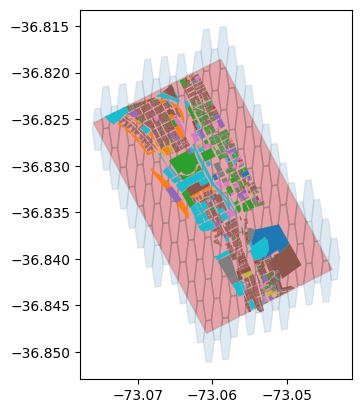

In [34]:
fig, ax = plt.subplots()
unit.plot(ax=ax, alpha=0.15, edgecolor='gray')
# area_scope.plot(ax=ax, edgecolor='black', color='red', alpha=0.3)
overlay_unit_area.plot(ax=ax, edgecolor='gray', color='red', alpha=0.3)
land_uses.plot(ax=ax, column='Uso')